# Figure 3

Steady-state solutions across a range of glucose levels.

In [1]:
using DifferentialEquations
using ModelingToolkit
using MitochondrialDynamics
import PythonPlot as plt
plt.matplotlib.rcParams["font.size"] = 14

14

baseline model

In [2]:
@named sys = make_model()
@unpack GlcConst, G3P, Pyr, ATP_c, ADP_c, NADH_c, NADH_m, Ca_m, ΔΨm, x1, x2, x3 = sys
prob = SteadyStateProblem(sys, [])
alg = DynamicSS(TRBDF2())
sol = solve(prob, alg)

retcode: Success
u: 9-element Vector{Float64}:
 0.05726539036425407
 0.0009825436375669918
 0.00020114170980325594
 0.09199008563917666
 0.0028280100032337524
 0.008756932513658807
 0.8765023198088248
 0.24323774801114825
 0.05868733028702013

Galactose model: glycolysis produces zero net ATP
By increasing the ATP consumed in the first part of glycolysis from 2 to 4

In [3]:
prob_gal = SteadyStateProblem(sys, [], [sys.ATPstiochGK => 4])

SteadyStateProblem with uType Vector{Float64}. In-place: true
u0: 9-element Vector{Float64}:
 0.057
 0.001
 0.0002
 0.092
 0.0029
 0.0087
 0.9
 0.24
 0.06

FFA model: Additional flux reducing mitochondrial NAD/NADH couple
A 10% increase w.r.t baseline CAC flux

In [4]:
prob_ffa = SteadyStateProblem(sys, [], [sys.kFFA => sol[0.10 * sys.J_DH / sys.NAD_m]])

SteadyStateProblem with uType Vector{Float64}. In-place: true
u0: 9-element Vector{Float64}:
 0.057
 0.001
 0.0002
 0.092
 0.0029
 0.0087
 0.9
 0.24
 0.06

Simulating on a range of glucose
Test on a range of glucose (3 mM to 30 mM)

In [5]:
glc = range(3.0, 30.0, step=0.3)

prob_func = (prob, i, repeat) -> begin
    remake(prob, p=[GlcConst => glc[i]])
end

trajectories = length(glc)

91

Run the simulations

In [6]:
sim = solve(EnsembleProblem(prob; prob_func, safetycopy=false), alg; trajectories)
sim_gal = solve(EnsembleProblem(prob_gal; prob_func, safetycopy=false), alg; trajectories)
sim_ffa = solve(EnsembleProblem(prob_ffa; prob_func, safetycopy=false), alg; trajectories);

## Steady states for a range of glucose

In [7]:
function plot_steady_state(glc, sols, sys; figsize=(10, 10), title="")

    @unpack G3P, Pyr, Ca_c, Ca_m, NADH_c, NADH_m, NAD_c, NAD_m, ATP_c, ADP_c, AMP_c, ΔΨm, x1, x2, x3, degavg = sys

    glc5 = glc ./ 5
    g3p = extract(sols, G3P * 1000)
    pyr = extract(sols, Pyr * 1000)
    ca_c = extract(sols, Ca_c * 1000)
    ca_m = extract(sols, Ca_m * 1000)
    nad_ratio_c = extract(sols, NADH_c / NAD_c)
    nad_ratio_m = extract(sols, NADH_m / NAD_m)
    atp_c = extract(sols, ATP_c * 1000)
    adp_c = extract(sols, ADP_c * 1000)
    amp_c = extract(sols, AMP_c * 1000)
    td = extract(sols, ATP_c / ADP_c)
    dpsi = extract(sols, ΔΨm * 1000)
    x1 = extract(sols, x1)
    x2 = extract(sols, x2)
    x3 = extract(sols, x3)
    deg = extract(sols, degavg)

    numrows = 3
    numcols = 3
    fig, axs = plt.subplots(numrows, numcols; figsize)

    axs[0, 0].plot(glc5, g3p)
    axs[0, 0].set(ylim=(0.0, 10.0), ylabel="G3P (μM)")
    axs[0, 0].set_title("a", loc="left")
    axs[0, 1].plot(glc5, pyr)
    axs[0, 1].set(ylabel="Pyruvate (μM)")
    axs[0, 1].set_title("b", loc="left")
    axs[0, 2].plot(glc5, ca_c, label="Ca (cyto)")
    axs[0, 2].plot(glc5, ca_m, label="Ca (mito)")
    axs[0, 2].legend()
    axs[0, 2].set(ylim=(0.0, 1.5), ylabel="Calcium (μM)")
    axs[0, 2].set_title("c", loc="left")
    axs[1, 0].plot(glc5, nad_ratio_c, label="cyto")
    axs[1, 0].plot(glc5, nad_ratio_m, label="mito")
    axs[1, 0].legend()
    axs[1, 0].set(ylabel="NADH:NAD (ratio)")
    axs[1, 0].set_title("d", loc="left")
    axs[1, 1].plot(glc5, atp_c, label="ATP")
    axs[1, 1].plot(glc5, adp_c, label="ADP")
    axs[1, 1].plot(glc5, amp_c, label="AMP")
    axs[1, 1].legend()
    axs[1, 1].set(ylabel="Adenylates (μM)")
    axs[1, 1].set_title("e", loc="left")
    axs[1, 2].plot(glc5, td)
    axs[1, 2].set(ylabel="ATP:ADP (ratio)")
    axs[1, 2].set_title("f", loc="left")
    axs[2, 0].plot(glc5, dpsi)
    axs[2, 0].set(xlabel="Glucose (X)", ylabel="ΔΨ (mV)")
    axs[2, 0].set_title("g", loc="left")
    axs[2, 1].plot(glc5, x1, label="X1")
    axs[2, 1].plot(glc5, x2, label="X2")
    axs[2, 1].plot(glc5, x3, label="X3")
    axs[2, 1].legend()
    axs[2, 1].set(xlabel="Glucose (X)", ylabel="Mitochondrial nodes (a.u.)")
    axs[2, 1].set_title("h", loc="left")
    axs[2, 2].plot(glc5, deg)
    axs[2, 2].set(xlabel="Glucose (X)", ylabel="Avg. node degree (a.u.)")
    axs[2, 2].set_title("i", loc="left")

    for i in 0:numrows-1, j in 0:numcols-1
        axs[i, j].set_xticks(1:6)
        axs[i, j].grid()
    end
    fig.suptitle(title)
    fig.tight_layout()
    return fig
end

plot_steady_state (generic function with 1 method)

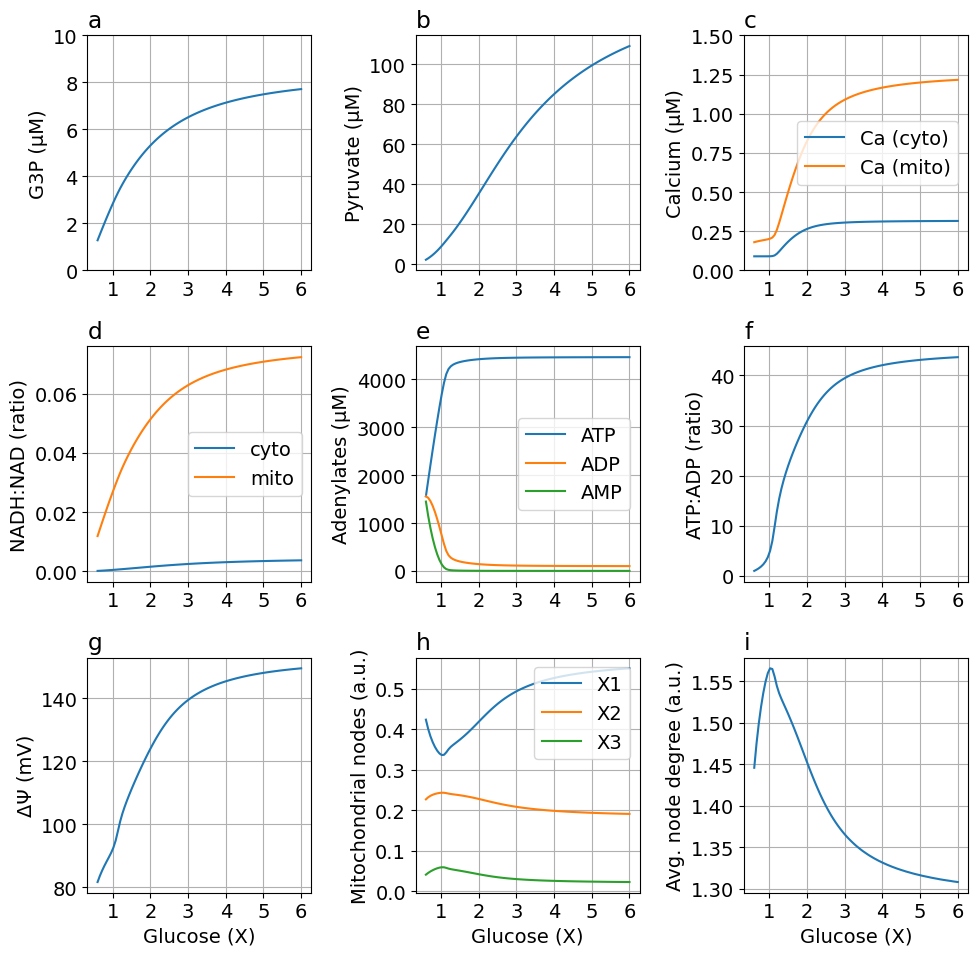

In [8]:
fig = plot_steady_state(glc, sim, sys, title="")

Default parameters

In [9]:
exportTIF(fig, "Fig3-steady-state.tif")

Python: None

Adding free fatty acids

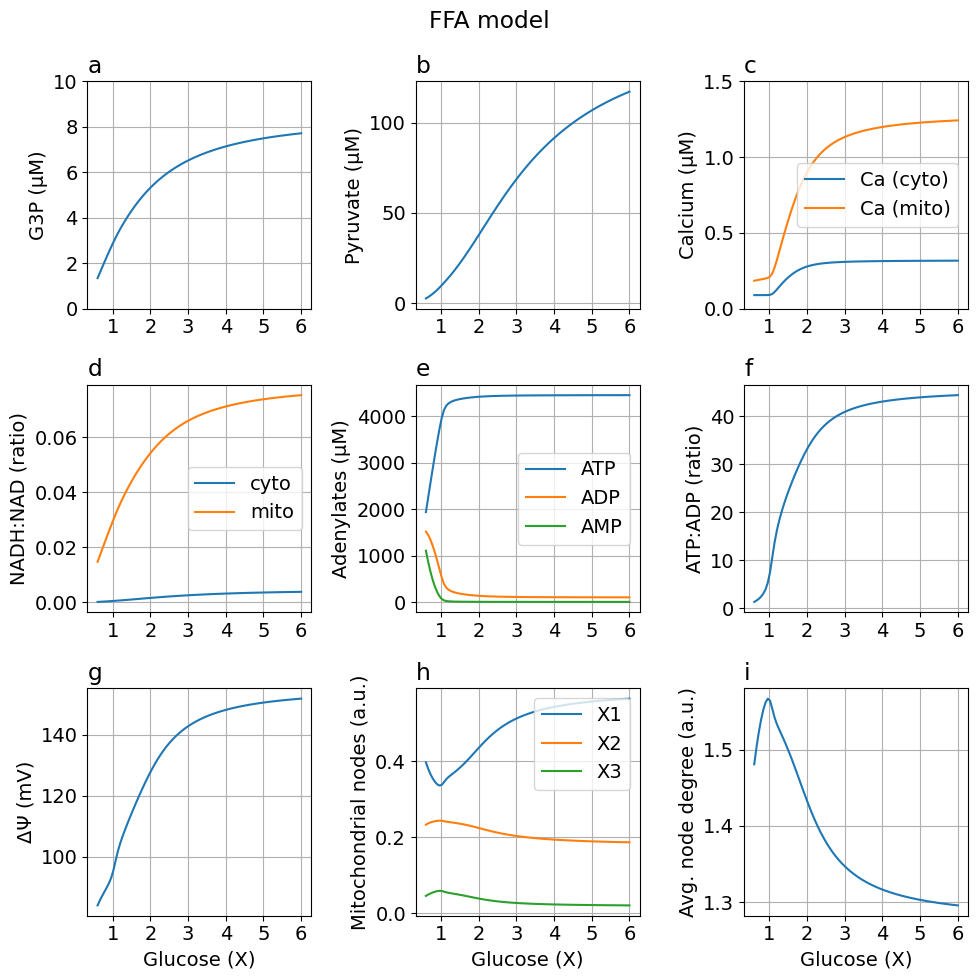

In [10]:
fig = plot_steady_state(glc, sim_ffa, sys, title="FFA model")

Using galactose instead of glucose as the hydrocarbon source

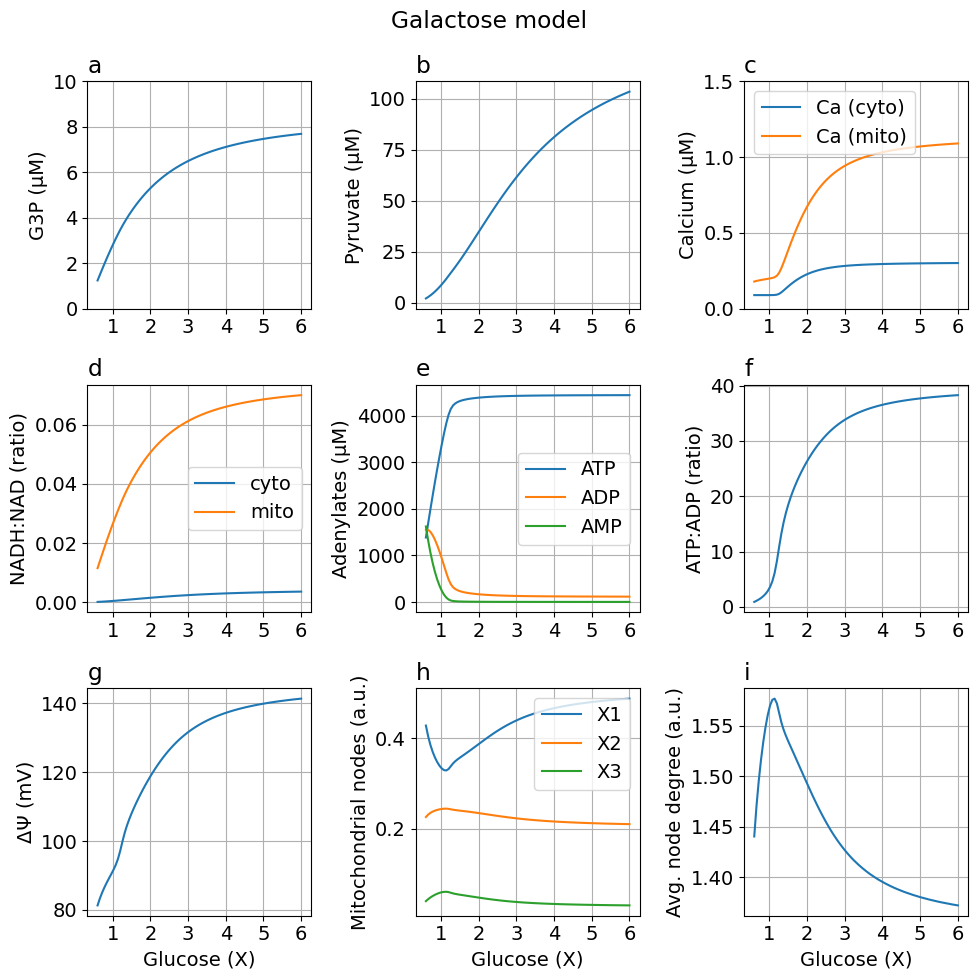

In [11]:
fig = plot_steady_state(glc, sim_gal, sys, title="Galactose model")

## Comparing default, FFA, and galactose models

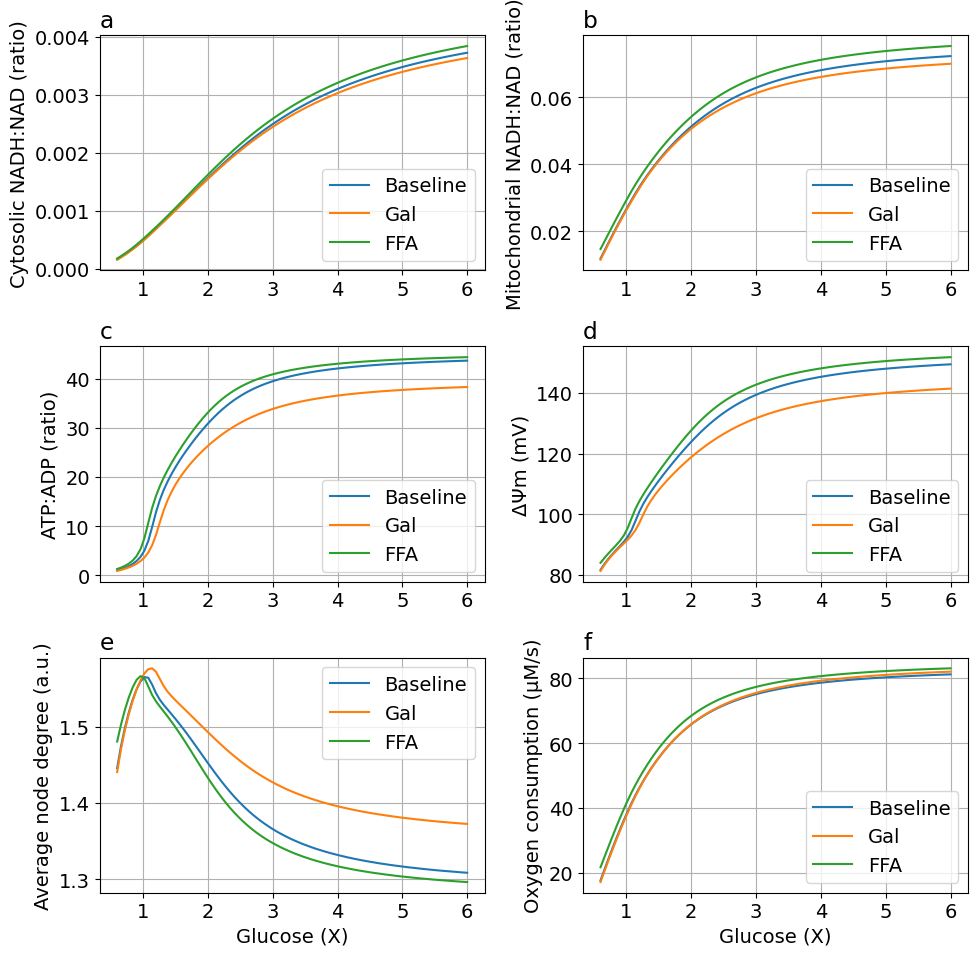

In [12]:
function plot_ffa_gal(glc, sim, sim_gal, sim_ffa, sys; figsize=(10, 10), title="", labels=["Baseline", "Gal", "FFA"])

    @unpack G3P, Pyr, Ca_c, Ca_m, NADH_c, NADH_m, NAD_c, NAD_m, ATP_c, ADP_c, AMP_c, ΔΨm, degavg, J_O2 = sys

    glc5 = glc ./ 5
    numcol = 2
    numrow = 3
    fig, axs = plt.subplots(numrow, numcol; figsize)

    axs[0, 0].set(ylabel="Cytosolic NADH:NAD (ratio)")
    axs[0, 0].set_title("a", loc="left")
    k = NADH_c / NAD_c
    yy = [extract(sim, k) extract(sim_gal, k) extract(sim_ffa, k)]
    lines = axs[0, 0].plot(glc5, yy)
    axs[0, 0].legend(lines, labels)

    axs[0, 1].set(ylabel="Mitochondrial NADH:NAD (ratio)")
    axs[0, 1].set_title("b", loc="left")
    k = NADH_m / NAD_m
    yy = [extract(sim, k) extract(sim_gal, k) extract(sim_ffa, k)]
    lines = axs[0, 1].plot(glc5, yy)
    axs[0, 1].legend(lines, labels)

    axs[1, 0].set(ylabel="ATP:ADP (ratio)")
    axs[1, 0].set_title("c", loc="left")
    k = ATP_c / ADP_c
    yy = [extract(sim, k) extract(sim_gal, k) extract(sim_ffa, k)]
    lines = axs[1, 0].plot(glc5, yy)
    axs[1, 0].legend(lines, labels)

    axs[1, 1].set(ylabel="ΔΨm (mV)")
    axs[1, 1].set_title("d", loc="left")
    k = ΔΨm * 1000
    yy = [extract(sim, k) extract(sim_gal, k) extract(sim_ffa, k)]
    lines = axs[1, 1].plot(glc5, yy)
    axs[1, 1].legend(lines, labels)

    axs[2, 0].set(ylabel="Average node degree (a.u.)")
    axs[2, 0].set_title("e", loc="left")
    k = degavg
    yy = [extract(sim, k) extract(sim_gal, k) extract(sim_ffa, k)]
    lines = axs[2, 0].plot(glc5, yy)
    axs[2, 0].legend(lines, labels)
    axs[2, 0].set(xlabel="Glucose (X)")

    k = J_O2 * 1000
    yy = [extract(sim, k) extract(sim_gal, k) extract(sim_ffa, k)]
    lines = axs[2, 1].plot(glc5, yy)
    axs[2, 1].legend(lines, labels)
    axs[2, 1].set(xlabel="Glucose (X)", ylabel="Oxygen consumption (μM/s)")
    axs[2, 1].set_title("f", loc="left")

    for i in 0:numrow-1, j in 0:numcol-1
        axs[i, j].set_xticks(1:6)
        axs[i, j].grid()
    end
    fig.suptitle(title)
    fig.tight_layout()
    return fig
end

figFFAGal = plot_ffa_gal(glc, sim, sim_gal, sim_ffa, sys)

Export figure

In [13]:
exportTIF(figFFAGal, "Fig-Base-Gal-FFA.tif")

Python: None

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*